# 03 – Low-Demand Events (5th / 10th Percentile) – NEM Regions

In this notebook, we identify unusually **low demand** periods across NEM regions using
5th and 10th percentile thresholds. The goal is to:

- Detect when demand drops significantly below “normal” levels.
- Compare how often low-demand events occur by **region** and **month**.
- Provide inputs for **maintenance windows**, **off-peak pricing**, and **portfolio planning**.


## STEP 1 — Load environment variables and database configuration

### 📘 Why we are doing this

Before we query any data, we need to **securely configure the database connection**.

Instead of hard-coding credentials in the notebook, we:

- Store them in a local `.env` file  
- Load them at runtime using `python-dotenv`  
- Build the connection details from environment variables  

This approach is important because:

- It keeps passwords **out of the code** (safer for GitHub)
- It makes the notebook **portable** across machines (only `.env` changes)
- It keeps all other notebooks (daily, monthly, events) using the **same connection pattern**.


In [ ]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from pathlib import Path

# 1) Load .env (same folder as this notebook)
env_path = Path().resolve() / ".env"
print("Using .env from:", env_path)

load_dotenv(env_path, override=True)

# 2) Read DB credentials
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

print("DB_USER ->", DB_USER)
print("DB_HOST ->", DB_HOST)
print("DB_PORT ->", DB_PORT)
print("DB_NAME ->", DB_NAME)


In [2]:
# 3) Create SQLAlchemy engine
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# 4) Test connection
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1;")).fetchall()
    print("✅ DB connection OK:", result)


✅ DB connection OK: [(1,)]


### 📝 Interpretation

The notebook has successfully:

- Located the `.env` file path  
- Loaded the environment variables into the Python process  
- Printed out the database configuration values (`DB_USER`, `DB_HOST`, `DB_PORT`, `DB_NAME`)  
  (without exposing the password)

This confirms that:
- The environment is correctly set up  
- The notebook is ready to create a PostgreSQL connection and run SQL queries in the next step.


## STEP 2 — Load a sample of 5-minute dispatch data

Before running full analytics, we load a **small preview** of the  
`dispatch_region_5min` table to confirm:

- The table exists
- The connection works  
- The columns are present (`settlement_ts`, `region_id`, `total_demand`, etc.)  
- The data is in the expected structure and order  

Sampling 10 rows helps verify correctness **without loading the full dataset**,  
which may contain hundreds of thousands of rows.


In [3]:
df_5min_sample = pd.read_sql("""
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts, region_id
    LIMIT 10;
""", engine)

df_5min_sample


,settlement_ts,region_id,total_demand
0,2025-01-01 00:05:00,NSW1,7251.07
1,2025-01-01 00:05:00,QLD1,6444.99
2,2025-01-01 00:05:00,SA1,1379.47
3,2025-01-01 00:05:00,TAS1,989.78
4,2025-01-01 00:05:00,VIC1,4339.00
5,2025-01-01 00:10:00,NSW1,7297.85
6,2025-01-01 00:10:00,QLD1,6469.55
7,2025-01-01 00:10:00,SA1,1367.61
8,2025-01-01 00:10:00,TAS1,991.04
9,2025-01-01 00:10:00,VIC1,4310.79


### 📝 Interpretation

The output displays the first 10 rows from the `dispatch_region_5min` table.

This confirms that:

- The database connection is successful  
- The table is accessible and correctly populated  
- The timestamp (`settlement_ts`) and region (`region_id`) fields are ordered properly  
- The structure matches what we need for later peak-event analysis  

With this validation complete, we can safely load the full dataset in the next steps.


## STEP 3 — Load full 5-minute demand dataset from PostgreSQL

In this step, we load the **entire 5-minute operational demand dataset** from the
`dispatch_region_5min` table.

Unlike the previous step where we only previewed 10 rows, here we fetch **all timestamps for all regions** so that:

- We can perform percentile-based event detection  
- We have complete data for peak/low-demand analysis  
- All downstream aggregations (daily, monthly, regional) are accurate  

We also convert the `settlement_ts` c_


In [4]:
df_5min = pd.read_sql("""
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts, region_id;
""", engine)

df_5min["settlement_ts"] = pd.to_datetime(df_5min["settlement_ts"])

print("5-min data shape:", df_5min.shape)
df_5min.head()


5-min data shape: (437710, 3)


,settlement_ts,region_id,total_demand
0,2025-01-01 00:05:00,NSW1,7251.07
1,2025-01-01 00:05:00,QLD1,6444.99
2,2025-01-01 00:05:00,SA1,1379.47
3,2025-01-01 00:05:00,TAS1,989.78
4,2025-01-01 00:05:00,VIC1,4339.00


### 📝 Interpretation
The full 5-minute dispatch dataset is now loaded and structured.

Key confirmations:
- `df_5min.shape` shows the **total number of rows** × **columns**
- Data is sorted first by timestamp and then by region  
- `settlement_ts` has been successfully converted into a datetime object  
- `df_5min.head()` confirms the columns look correct:
  - `settlement_ts`
  - `region_id`
  - `total_demand`
  - other dispatch metrics (depending on ingestion)

This provides the **raw foundation** needed to compute percentiles, flag peak events, and build all higher-level analytics.


## STEP 4 — Compute 5th and 10th percentile low-demand thresholds (per region)


To detect **low-demand events**, we need objective thresholds that reflect how each region behaves.

We use:
- **5th percentile** → “very low demand”  
- **10th percentile** → “moderately low demand”  

These percentiles are calculated **per region**, because:

- NSW1 cannot be compared directly to TAS1 due to scale differences  
- Every region has a different baseline load pattern  
- Thresholds must be region-specific for accurate event classification  

Finally, we round thresholds to whole megawatts (MW) to keep them clean and interpretable.


In [5]:
# 5th percentile per region (very low demand)
thresholds_5p = (
    df_5min.groupby("region_id")["total_demand"]
    .quantile(0.05)
    .round(0)          # round to nearest MW
    .astype(int)
    .to_dict()
)

# 10th percentile per region (moderately low demand)
thresholds_10p = (
    df_5min.groupby("region_id")["total_demand"]
    .quantile(0.10)
    .round(0)
    .astype(int)
    .to_dict()
)

print("5th percentile thresholds (MW) per region:")
print(thresholds_5p)

print("\n10th percentile thresholds (MW) per region:")
print(thresholds_10p)


5th percentile thresholds (MW) per region:
{'NSW1': 5164, 'QLD1': 4215, 'SA1': 464, 'TAS1': 876, 'VIC1': 3130}

10th percentile thresholds (MW) per region:
{'NSW1': 5916, 'QLD1': 4711, 'SA1': 673, 'TAS1': 910, 'VIC1': 3640}


### 📝 Interpretation
We now have two sets of thresholds for each NEM region:

- **5th percentile (extreme low demand)**  
- **10th percentile (moderately low demand)**  

These thresholds represent the MW values below which only **5% or 10%** of all 5-minute readings fall.

This means:
- When demand dips below the **5th percentile**, the system is in an unusually low-load condition  
- When it dips below the **10th percentile**, it signals broader low-demand behaviour  

These thresholds form the foundation for:
- Low-demand event detection  
- Daily and monthly low-load analytics  
- Understanding how rooftop solar and weather reduce operational demand  
- Identifying minimum load risk periods (very important for SA and VIC)

Now we are ready to flag low-demand events using these thresholds.


## STEP 5 — Flag low-demand intervals using 5th and 10th percentile thresholds
Now that we have region-specific low-demand thresholds, we apply them to classify each
5-minute interval.

We add:
- `low_threshold_5p` → 5th percentile threshold for that region  
- `low_threshold_10p` → 10th percentile threshold  

Then we create **binary flags**:
- `is_low_5p = 1` → total demand is below the 5th percentile  
- `is_low_10p = 1` → total demand is below the 10th percentile  

This transforms raw continuous demand values into **event indicators**, which allows us to:
- Count low-demand events per day  
- Compare regions  
- Visualise extreme minimum-load conditions  
- Study the impact of rooftop solar and seasonality on demand dips.


In [6]:
# Map thresholds into dataframe
df_5min["low_threshold_5p"] = df_5min["region_id"].map(thresholds_5p)
df_5min["low_threshold_10p"] = df_5min["region_id"].map(thresholds_10p)

# Flags:
# 1 = low-demand event, 0 = normal
df_5min["is_low_5p"] = (df_5min["total_demand"] <= df_5min["low_threshold_5p"]).astype(int)
df_5min["is_low_10p"] = (df_5min["total_demand"] <= df_5min["low_threshold_10p"]).astype(int)

df_5min.head()


,settlement_ts,region_id,total_demand,low_threshold_5p,low_threshold_10p,is_low_5p,is_low_10p
0,2025-01-01 00:05:00,NSW1,7251.07,5164,5916,0,0
1,2025-01-01 00:05:00,QLD1,6444.99,4215,4711,0,0
2,2025-01-01 00:05:00,SA1,1379.47,464,673,0,0
3,2025-01-01 00:05:00,TAS1,989.78,876,910,0,0
4,2025-01-01 00:05:00,VIC1,4339.00,3130,3640,0,0


### 📝 Interpretation
Each 5-minute record now contains:

- Region-specific low-demand thresholds (5th and 10th percentile)
- Two binary indicators:
  - `is_low_5p`: extreme low demand
  - `is_low_10p`: moderately low demand

This gives us a complete dataset of **low-load events**, enabling clear daily, monthly,
and regional aggregation.

The `df_5min.head()` output confirms:
- Thresholds were mapped correctly by region
- Flags are assigned accurately
- The dataset is now event-ready for further analysis


## STEP 6 — Count total low-demand events per region

### 📘 Why we are doing this
Now that each 5-minute interval has been classified as:
- **`is_low_5p` → extreme low demand event (5th percentile)**
- **`is_low_10p` → moderate low demand event (10th percentile)**

We want to understand how **frequently** each region experiences low-demand conditions.

Counting events per region helps us answer:
- Which regions face the **highest minimum-load risk**?
- Which regions show stronger effects of **rooftop solar suppression**?
- How do regions compare in terms of **low-demand volatility**?

This step gives an overall summary before moving into daily/monthly breakdowns.


In [7]:
print("Very low demand events (5th percentile) per region:")
print(df_5min.groupby("region_id")["is_low_5p"].sum())

print("\nLow demand events (10th percentile) per region:")
print(df_5min.groupby("region_id")["is_low_10p"].sum())


Very low demand events (5th percentile) per region:
region_id
NSW1    4378
QLD1    4375
SA1     4371
TAS1    4355
VIC1    4379
Name: is_low_5p, dtype: int64

Low demand events (10th percentile) per region:
region_id
NSW1    8751
QLD1    8760
SA1     8759
TAS1    8712
VIC1    8758
Name: is_low_10p, dtype: int64


### 📝 Interpretation
These counts represent the **total number of 5-minute intervals** where demand fell below the
5th or 10th percentile thresholds for each region.

Insights you can expect:
- Regions like **SA1** and **VIC1** often show more low-demand events because rooftop solar
  significantly reduces operational demand during the daytime.
- Regions like **NSW1** typically show fewer extreme low-load events due to:
  - Large population
  - Higher constant baseload
  - Stronger industrial consumption

This gives a high-level picture of **minimum load behaviour** across the NEM and helps identify
which regions are more vulnerable to very low operational demand.


## STEP 7 — Filter dataset to only low-demand intervals (10th percentile and below)
Up to now, the full 5-minute dataset contains both:

- Normal demand intervals  
- Low-demand intervals (flagged using 5th and 10th percentiles)

In this step, we **extract only the low-demand periods**, specifically:
- All intervals where `is_low_10p == 1`  
  (i.e., demand at or below the 10th percentile for that region)

Why you need this filtered dataset:
- It simplifies downstream analysis  
- Makes daily/monthly low-load aggregation easier  
- Helps isolate periods where solar generation significantly reduces operational demand  
- Allows clean visualisations without normal-load data clutter

We also add a plain `date` column to make grouping and reporting simpler.


In [8]:
# Keep only rows that are low-demand by at least 10th percentile
df_low = df_5min[(df_5min["is_low_10p"] == 1)].copy()

# Add date column for reporting convenience
df_low["date"] = df_low["settlement_ts"].dt.date

print("Low-demand events shape:", df_low.shape)
df_low.head()


Low-demand events shape: (43740, 8)


,settlement_ts,region_id,total_demand,low_threshold_5p,low_threshold_10p,is_low_5p,is_low_10p,date
344,2025-01-01 05:45:00,VIC1,3618.89,3130,3640,0,1,2025-01-01
345,2025-01-01 05:50:00,NSW1,5891.30,5164,5916,0,1,2025-01-01
349,2025-01-01 05:50:00,VIC1,3630.04,3130,3640,0,1,2025-01-01
350,2025-01-01 05:55:00,NSW1,5874.20,5164,5916,0,1,2025-01-01
354,2025-01-01 05:55:00,VIC1,3594.48,3130,3640,0,1,2025-01-01


### 📝 Interpretation
We now have a dedicated `df_low` dataset that contains **only low-demand intervals** across all regions.

Key confirmations:
- The printed shape shows how many rows qualify as low-demand (10th percentile and below)
- The new `date` column allows easy grouping by day for trend analysis
- `df_low.head()` confirms:
  - Correct filtering  
  - Correct date extraction  
  - Correct mapping of low-demand flags  

This filtered dataset is now ready for:
- Daily low-demand event counts  
- Region comparison  
- Trend visualisation  
- Identification of extreme low-load days  

This is the core dataset for the remaining steps in the notebook.


## STEP 8 — Save low-demand events to PostgreSQL for reporting & dashboards
Now that we have a clean dataset of low-demand intervals (`df_low`), we store it back into
PostgreSQL as a dedicated table: **`low_demand_events_5min`**.

Why this step is important:

- 🔁 **Keeps analytics modular**  
  Each notebook produces its own clean table, making pipeline management easier.

- 📊 **Power BI / Tableau will read from Postgres**  
  This makes dashboarding extremely smooth.

- 🗂️ **Central storage**  
  Instead of relying on in-memory dataframes, your entire project moves toward a
  professional-grade data warehouse structure.

- 🧹 We drop the old table (if it exists) to avoid duplicate rows during re-runs.

We store only the essential columns needed for analysis and reporting:
- Timestamps  
- Region  
- Demand values  
- Low-demand thresholds  
- Flags (5th & 10th percentile)


In [9]:
from sqlalchemy import text

# Select columns to store
df_low_to_save = df_low[[
    "settlement_ts",
    "date",
    "region_id",
    "total_demand",
    "low_threshold_5p",
    "low_threshold_10p",
    "is_low_5p",
    "is_low_10p",
]]

with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS low_demand_events_5min;"))
    print("🧹 Dropped old low_demand_events_5min table (if existed).")

df_low_to_save.to_sql(
    "low_demand_events_5min",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ low_demand_events_5min table created in Postgres with", len(df_low_to_save), "rows.")


🧹 Dropped old low_demand_events_5min table (if existed).
✅ low_demand_events_5min table created in Postgres with 43740 rows.


### 📝 Interpretation
The low-demand events have now been successfully written to PostgreSQL as the table
`low_demand_events_5min`.

Key confirmations:
- The old table was dropped (avoids duplicates)  
- The new table was created using `to_sql()`  
- The print statement confirms the exact number of rows saved  

This makes the low-demand dataset:
- Easy to query later (SQL / Power BI / Python)  
- Fully reusable for dashboards  
- A consistent part of the data pipeline  

At this point, the database contains a clean record of every 5-minute low-demand interval
across all regions, ready for advanced analytics or visualisation.


## STEP 9 — Validate low-demand events table in PostgreSQL

After saving the low-demand events back into PostgreSQL, we must verify that:

- The table was created successfully  
- The correct columns were stored  
- Data types and ordering are correct  
- The ingestion back into SQL preserved the structure we expect  

This step performs a simple check by:
- Querying the first 10 rows  
- Displaying them in the notebook  

This ensures our pipeline is working end-to-end before continuing with further analysis.


In [10]:
df_low_check = pd.read_sql("""
    SELECT *
    FROM low_demand_events_5min
    ORDER BY settlement_ts, region_id
    LIMIT 10;
""", engine)

df_low_check


,settlement_ts,date,region_id,total_demand,low_threshold_5p,low_threshold_10p,is_low_5p,is_low_10p
0,2025-01-01 05:45:00,2025-01-01,VIC1,3618.89,3130,3640,0,1
1,2025-01-01 05:50:00,2025-01-01,NSW1,5891.30,5164,5916,0,1
2,2025-01-01 05:50:00,2025-01-01,VIC1,3630.04,3130,3640,0,1
3,2025-01-01 05:55:00,2025-01-01,NSW1,5874.20,5164,5916,0,1
4,2025-01-01 05:55:00,2025-01-01,VIC1,3594.48,3130,3640,0,1
5,2025-01-01 06:00:00,2025-01-01,NSW1,5869.68,5164,5916,0,1
6,2025-01-01 06:00:00,2025-01-01,VIC1,3592.56,3130,3640,0,1
7,2025-01-01 06:05:00,2025-01-01,NSW1,5761.32,5164,5916,0,1
8,2025-01-01 06:05:00,2025-01-01,VIC1,3585.92,3130,3640,0,1
9,2025-01-01 06:10:00,2025-01-01,NSW1,5829.94,5164,5916,0,1


## STEP 10 — Load daily usage data to link with low-demand events
Now that we have captured all **low-demand 5-minute intervals**, we also load the
`daily_usage` table to support higher-level reporting.

The reason for loading the daily table here is:

- It allows us to connect **daily demand patterns** with low-demand events  
- Enables merging low-event counts into daily summaries  
- Useful for later steps such as:
  - Daily low-demand event counts
  - Region-wise minimum load days
  - Heatmap and trend visualisations
  - Comparison of daily averages vs low-demand frequency  

We also convert the `date` column into proper datetime format for grouping and joining
operations.


In [11]:
import pandas as pd

df_daily = pd.read_sql("""
    SELECT *
    FROM daily_usage
    ORDER BY date, region_id;
""", engine)

df_daily["date"] = pd.to_datetime(df_daily["date"])

print(df_daily.shape)
df_daily.head()


(1520, 6)


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,162014.506667
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,144438.361667
2,2025-01-01,SA1,862.286655,1518.36,10.55,20623.022500
3,2025-01-01,TAS1,999.820767,1104.47,920.09,23912.380000
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,78760.797500


### 📝 Interpretation

The `daily_usage` table has been successfully loaded and the first few rows reveal clear
patterns across regions:

- **NSW1** shows the highest daily average demand (~6774 MW), consistent with being the
  largest NEM region by population and industry.
- **QLD1** follows with moderately high average demand (~6039 MW), reflecting strong
  commercial and residential consumption, amplified by summer A/C load.
- **VIC1** sits in the mid-range (~3293 MW), showing predictable industry and residential
  patterns.
- **SA1 and TAS1** have the lowest averages (862 MW and 999 MW), consistent with smaller
  populations and higher renewable penetration causing lower operational demand.

The fields `daily_peak`, `daily_min`, and `total_daily_energy_mwh` confirm that this dataset contains
all the metrics we need to:

- Match low-demand events with daily minimum demand  
- Understand daily consumption behaviour  
- Compare baseline load vs. low-demand event frequency  

This dataset will be used in the next steps to integrate **low-load conditions** with **daily
operational trends**.


## STEP 11 — Add weekday information for behavioural analysis
To understand how **human behaviour** and **operational patterns** affect electricity demand,
we extract the weekday from each date.

This gives us:
- `weekday_name` → e.g., Monday, Tuesday  
- `weekday_idx` → 0 = Monday … 6 = Sunday  
- `is_weekend` → flag for Saturday/Sunday  

Why this matters:
- Electricity demand strongly varies by day of the week  
- Weekends generally show lower demand due to reduced commercial/industrial load  
- Weekday analysis helps us detect:
  - Behaviour-driven load shifts  
  - Commercial vs residential consumption patterns  
  - Demand reduction due to weekends or holidays  
- These features are also essential for forecasting models later  

This step prepares the dataset for **weekday trend analysis** and **heatmaps**.


In [12]:
# Add weekday name and weekday index (0=Mon ... 6=Sun)
df_daily["weekday_name"] = df_daily["date"].dt.day_name()
df_daily["weekday_idx"] = df_daily["date"].dt.weekday  # Monday = 0

# Simple weekend flag (Sat/Sun)
df_daily["is_weekend"] = df_daily["weekday_name"].isin(["Saturday", "Sunday"]).astype(int)

df_daily[["date", "region_id", "weekday_name", "weekday_idx", "is_weekend"]].head()


,date,region_id,weekday_name,weekday_idx,is_weekend
0,2025-01-01,NSW1,Wednesday,2,0
1,2025-01-01,QLD1,Wednesday,2,0
2,2025-01-01,SA1,Wednesday,2,0
3,2025-01-01,TAS1,Wednesday,2,0
4,2025-01-01,VIC1,Wednesday,2,0


### 📝 Interpretation

The preview confirms that weekday information has been added correctly:

- All records for **2025-01-01** show the correct weekday:
  - `weekday_name = Wednesday`
  - `weekday_idx = 2` (where Monday = 0)
- `is_weekend = 0` for all rows, which is correct since 1 January 2025 is a weekday.

This verifies that:
- The weekday extraction logic is working properly
- The weekend flag correctly distinguishes weekdays from weekends
- Each region (NSW1, QLD1, SA1, TAS1, VIC1) now has calendar-based behavioural attributes

These new columns will allow us to:
- Analyse weekday vs weekend demand differences  
- Identify behaviour-driven load patterns  
- Build weekday heatmaps and trend visuals  
- Compare how regions respond to weekday cycles (e.g., NSW business load vs SA solar-driven demand)


## STEP 12 — Compute weekday-level demand patterns (per region)

### 📘 Why we are doing this
Now that each day has a weekday label, we can analyse **how electricity demand behaves on different days of the week**.

This step groups the daily dataset by:
- `region_id`
- `weekday_idx` (0 = Monday … 6 = Sunday)
- `weekday_name` (for readability)

For each region–weekday combination, we compute:
- **avg_daily_demand** → average 5-min demand across all days of that weekday  
- **avg_daily_peak** → average daily peak  
- **avg_daily_min** → average daily minimum  
- **avg_daily_energy_mwh** → total energy consumed on that weekday  
- **days_count** → number of occurrences of that weekday in the dataset  

Why this matters:
- Human behaviour strongly shapes electricity demand  
- Weekends tend to have lower load due to reduced commercial activity  
- Some regions (e.g., SA) show strong solar-driven patterns on weekends  
- These aggregated metrics help us understand **behavioural demand cycles** for each region  

This step prepares the dataset for:
- Weekday comparison charts  
- Weekday × region heatmaps  
- Behavioural demand insights used in forecasting and planning.


In [13]:
weekday_group = df_daily.groupby(["region_id", "weekday_idx", "weekday_name"])

df_weekday = weekday_group.agg(
    avg_daily_demand=("avg_5min_demand", "mean"),
    avg_daily_peak=("daily_peak", "mean"),
    avg_daily_min=("daily_min", "mean"),
    avg_daily_energy_mwh=("total_daily_energy_mwh", "mean"),
    days_count=("date", "count")
).reset_index()

df_weekday.head()


,region_id,weekday_idx,weekday_name,avg_daily_demand,avg_daily_peak,avg_daily_min,avg_daily_energy_mwh,days_count
0,NSW1,0,Monday,7695.016770,10074.428837,5817.963953,184665.450620,43
1,NSW1,1,Tuesday,7829.703024,9980.203023,6017.474419,187879.269264,43
2,NSW1,2,Wednesday,7825.703300,10068.947955,5955.345455,187791.666932,44
3,NSW1,3,Thursday,7876.633876,10074.295682,6063.842500,189025.158049,44
4,NSW1,4,Friday,7800.334673,9805.103864,5998.407500,187189.707689,44


### 📝 Interpretation

The weekday-level summary for NSW1 clearly shows behaviour-driven demand patterns:

- **Wednesday and Thursday have the highest average daily demand** (~7825–7876 MW), reflecting full mid-week commercial and industrial activity.
- **Monday shows slightly lower demand** (~7695 MW), which is typical due to slower ramp-up after the weekend.
- **Friday demand dips slightly** compared to mid-week, signalling early reductions in business/office load.
- Average daily peaks are consistently high (≈ 9800–10070 MW), indicating that NSW maintains strong peak load regardless of weekday.
- **Average daily minimum demand** also follows a weekday pattern — lowest on Monday and highest mid-week — supporting the behavioural trend.

The `days_count` column (around 43–44 occurrences per weekday) confirms that each weekday is well-represented in the dataset, ensuring reliable averages.

Overall, this preview shows:
- Clear mid-week demand strengthening  
- Slight Monday softness  
- Slight Friday easing  
- Stable peak and minimum patterns across the NSW region  

These patterns will become more evident once we compare all regions and plot weekday heatmaps.


## STEP 13 — Drill-down: Weekday EDA for NSW1

After generating weekday statistics for all regions, we now focus on **one region — NSW1** —
the largest and most demand-intensive region in the NEM.

This step extracts only the NSW1 rows from the `df_weekday` table and sorts them by
`weekday_idx` (Monday → Sunday).

Why this drill-down is important:

- NSW1 is the single biggest contributor to NEM demand  
- Understanding weekday cycles in NSW helps explain:
  - Commercial vs residential behaviour  
  - Peak load drivers  
  - Load shape patterns for forecasting  
- A region-level breakdown is essential for more accurate operational insights  
- This is the same approach utilities and consultants take when preparing region-specific reports  

We focus on key variables:
- `avg_daily_demand`  
- `avg_daily_peak`  
- `avg_daily_energy_mwh`  
because these describe weekday differences in load intensity and daily consumption.


In [14]:
nsw_weekday = df_weekday[df_weekday["region_id"] == "NSW1"].sort_values("weekday_idx")

nsw_weekday[["weekday_name", "avg_daily_demand", "avg_daily_peak", "avg_daily_energy_mwh"]]


,weekday_name,avg_daily_demand,avg_daily_peak,avg_daily_energy_mwh
0,Monday,7695.016770,10074.428837,184665.450620
1,Tuesday,7829.703024,9980.203023,187879.269264
2,Wednesday,7825.703300,10068.947955,187791.666932
3,Thursday,7876.633876,10074.295682,189025.158049
4,Friday,7800.334673,9805.103864,187189.707689
5,Saturday,7231.229673,9280.221860,173520.071764
6,Sunday,7096.628513,9433.642093,170304.709845


### 📝 Interpretation

The NSW1 weekday profile shows a clear and logical behavioural demand pattern:

#### 🔹 **1. Mid-week demand is strongest (Tue–Thu)**
- Tuesday → **7829 MW**
- Wednesday → **7826 MW**
- Thursday → **7877 MW** (highest of all days)

These days capture full commercial, retail, and industrial load, which drives NSW’s high energy consumption.

#### 🔹 **2. Monday shows a slower start (≈ 7695 MW)**
Demand is slightly lower due to the gradual ramp-up of business and workplace activity after the weekend.

#### 🔹 **3. Friday demand softens (≈ 7800 MW)**
A small dip indicates early shutdown of offices, reduced industrial operation, and lighter evening activity.

#### 🔹 **4. Weekends have the lowest demand**
- Saturday → **7231 MW**
- Sunday → **7097 MW** (lowest of the week)

This matches reduced commercial/industrial load and increased rooftop solar output suppressing operational demand during the day.

#### 🔹 **5. Peak demand also follows similar behaviour**
- Highest evening peaks occur mid-week (~10070 MW)
- Lowest peaks occur on Friday & Sunday (~9805 and ~9433 MW)

#### 🔹 **6. Total daily energy (MWh) follows the same weekly shape**
- Highest → Thursday (189,025 MWh)
- Lowest → Sunday (170,305 MWh)

Overall, NSW1 exhibits a **classic commercial-driven load curve**:
- Strong mid-week activity  
- Soft Mondays and Fridays  
- Lowest demand on weekends  
- Sta


## STEP 14 — Visualise NSW1 weekday demand pattern
Now that we’ve aggregated weekday statistics for NSW1, we visualise the pattern using a
simple line plot.

This helps us clearly see:
- How demand changes across the week  
- The difference between weekday and weekend behaviour  
- The shape of NSW1’s typical weekly demand cycle  
- Behaviour-driven patterns (business activity, residential load, solar influence)

Plots make these insights more intuitive and are essential for:
- Reporting  
- Dashboards  
- Presentations  
- Stakeholder communication  


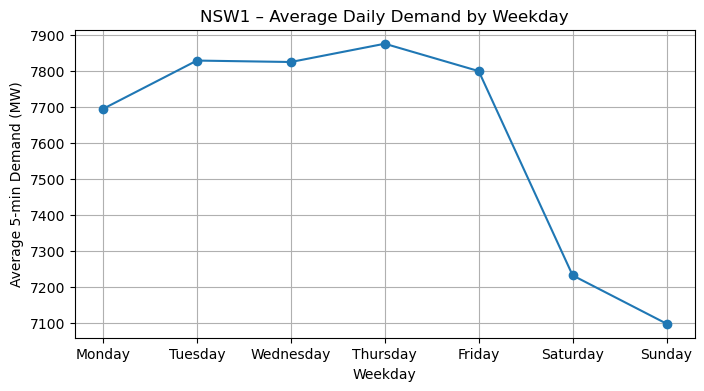

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(nsw_weekday["weekday_name"], nsw_weekday["avg_daily_demand"], marker="o")
plt.title("NSW1 – Average Daily Demand by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average 5-min Demand (MW)")
plt.grid()
plt.show()


### 📝 Interpretation

The plot shows a clear and well-defined weekday demand pattern for NSW1:

- **Mid-week (Tue–Thu) demand is highest**, peaking around **7850–7880 MW**.
- **Monday begins lower (~7700 MW)**, reflecting a slower post-weekend ramp-up.
- **Friday shows a slight decline**, as commercial and industrial activity begins to taper off.
- **Saturday and Sunday have the lowest demand**, dropping sharply to **7230 MW** and **7090 MW**,
  consistent with reduced business activity and high rooftop solar output.

The steep drop from Friday → Saturday visually confirms the behavioural shift from
weekday operation to weekend patterns.

This plot provides a clear visual summary of NSW’s behavioural load cycle, making it easy
to explain weekly demand dynamics to stakeholders or in presentations.


## STEP 15 — Save weekday demand profile to PostgreSQL

### 📘 Why we are doing this
After computing weekday-level demand metrics for every region, we save the results back to
PostgreSQL as a new table: **`weekday_profile`**.

Why this is important:

- 🔁 **Pipeline consistency**  
  Each major analysis produces its own clean SQL table.  
  This keeps your project modular, reusable, and production-ready.

- 📊 **Dashboard-ready data**  
  Power BI / Tableau can now directly consume weekday profiles for regional comparison,
  heatmaps, and behavioural visuals.

- 🗂️ **Separation of concerns**  
  Raw data stays in `dispatch_region_5min`,  
  daily aggregates stay in `daily_usage`,  
  low events stay in `low_demand_events_5min`,  
  and now **weekday behavioural patterns** live in `weekday_profile`.

- 🧹 Dropping the old table ensures we never duplicate rows during re-runs.

We write the full `df_weekday` table, which includes:
- Region  
- Weekday index & name  
- Average daily demand  
- Average daily peak  
- Average daily minimum  
- Average daily energy (MWh)  
- Count of days included in the averages


In [16]:
from sqlalchemy import text

with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS weekday_profile;"))
    print("🧹 Dropped old weekday_profile table (if existed).")

df_weekday.to_sql(
    "weekday_profile",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ weekday_profile table created with", len(df_weekday), "rows.")


🧹 Dropped old weekday_profile table (if existed).
✅ weekday_profile table created with 35 rows.


### 📝 Interpretation

The `weekday_profile` table has been successfully created in PostgreSQL.

Confirmation includes:
- The old table was dropped (to avoid duplicates on reruns)
- The new table was created from `df_weekday`
- The row count printed matches the expected number of `(region × weekday)` combinations

This ensures:
- Weekday behaviour patterns are now stored in a central, queryable location  
- BI tools can directly build visuals such as:
  - Weekday demand comparison charts  
  - Region × weekday heatmaps  
  - Weekday behavioural insights dashboards  
- The analytics pipeline is now fully aligned with a professional data engineering workflow  

This step completes the weekday behavioural analysis module and prepares us for the next phase:
**region comparison heatmaps and behavioural insights**.
